In [272]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import math

import matplotlib.pyplot as plt

import imageio
import numpy as np
import torch.nn.functional as F

In [273]:
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

dataset = ImageFolder("data/dog_dataset/", transform=transform)
loader = DataLoader(dataset, batch_size=8, shuffle=True)



In [274]:
print("Dataset size:", len(dataset))
print("Classes:", dataset.classes)

x, y = dataset[0]
print("Image shape:", x.shape)
print("Label:", y)

Dataset size: 33
Classes: ['dog']
Image shape: torch.Size([3, 32, 32])
Label: 0


In [275]:
T = 1000

betas = torch.linspace(1e-4, 0.02, T)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)

In [276]:
def q_sample(x0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x0)

    sqrt_alpha_bar = alphas_cumprod[t] ** 0.5
    sqrt_one_minus = (1 - alphas_cumprod[t]) ** 0.5

    return sqrt_alpha_bar * x0 + sqrt_one_minus * noise

In [277]:
def show_samples(samples, epoch, n=4):
    """
    samples: (B, 3, H, W) in [-1, 1]
    """
    samples = (samples + 1) / 2
    samples = samples.clamp(0, 1)
    samples = samples.cpu()

    fig, axes = plt.subplots(1, n, figsize=(3*n, 3))
    for i in range(n):
        img = samples[i].permute(1, 2, 0)  # CHW -> HWC
        axes[i].imshow(img)
        axes[i].axis("off")

    plt.suptitle(f"Epoch {epoch}")
    plt.show()

In [278]:
import math

def sinusoidal_embedding(timesteps, dim):
    """
    timesteps: (B,) int64 or float
    returns: (B, dim)
    """
    device = timesteps.device
    half_dim = dim // 2

    emb = math.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, device=device) * -emb)

    emb = timesteps[:, None].float() * emb[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)

    return emb

class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim),
            nn.ReLU(),
            nn.Linear(dim, dim)
        )

    def forward(self, t):
        emb = sinusoidal_embedding(t, dim=self.net[0].in_features)
        return self.net(emb)

In [279]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        return self.block(x)

class TinyUNet(nn.Module):
    def __init__(self, time_dim=32):
        super().__init__()

        self.time_dim = time_dim

        # time embedding MLP
        self.time_mlp = nn.Sequential(
            nn.Linear(time_dim, time_dim),
            nn.ReLU()
        )

        # ⬇️ ADD THIS
        self.time_to_mid = nn.Linear(time_dim, 64)

        # down
        self.down1 = ConvBlock(3, 32)
        self.down2 = ConvBlock(32, 64)
        self.pool = nn.MaxPool2d(2)

        # bottleneck
        self.mid = ConvBlock(64, 64)

        # up
        self.up2 = ConvBlock(64 + 64, 32)
        self.up1 = ConvBlock(32 + 32, 32)

        self.upsample = nn.Upsample(scale_factor=2, mode="nearest")
        self.out = nn.Conv2d(32, 3, 1)

    def forward(self, x, t):
        # time embedding
        t_emb = sinusoidal_embedding(t, self.time_dim)
        t_emb = self.time_mlp(t_emb)
        t_emb = self.time_to_mid(t_emb)
        t_emb = t_emb[:, :, None, None]

        # down
        d1 = self.down1(x)              # 32×32
        d2 = self.down2(self.pool(d1))  # 16×16

        # bottleneck
        mid = self.mid(d2 + t_emb)      # 16×16

        # up (FIXED)
        u2 = self.up2(torch.cat([mid, d2], dim=1))  # 16×16
        u2 = self.upsample(u2)                      # 32×32

        u1 = self.up1(torch.cat([u2, d1], dim=1))   # 32×32

        return self.out(u1)

In [280]:
class TinyDenoiser(nn.Module):
    def __init__(self):
        super().__init__()

        self.time_embed = TimeEmbedding(32)

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 3, 3, padding=1)

    def forward(self, x, t):
        # t is (B,)
        t_emb = self.time_embed(t)          # (B, 32)
        t_emb = t_emb[:, :, None, None]     # (B, 32, 1, 1)
        

        h = self.conv1(x)
        h = h + t_emb
        h = F.relu(h)

        h = F.relu(self.conv2(h))
        return self.conv3(h)

In [281]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [282]:
@torch.no_grad()
def sample_ddim(
    model,
    shape=None,
    x_init=None,
    steps=50,
):
    """
    Deterministic DDIM sampling.
    """
    model.eval()

    if x_init is not None:
        x = x_init.clone()
    else:
        x = torch.randn(shape).to(device)

    # choose timesteps (uniformly spaced)
    timesteps = torch.linspace(T - 1, 0, steps, dtype=torch.long)

    for i in range(len(timesteps) - 1):
        t = timesteps[i]
        t_next = timesteps[i + 1]

        t_batch = torch.full((x.size(0),), t, device=device, dtype=torch.long)

        eps = model(x, t_batch)

        alpha_t = alphas_cumprod[t]
        alpha_next = alphas_cumprod[t_next]

        # predict x0
        x0 = (x - torch.sqrt(1 - alpha_t) * eps) / torch.sqrt(alpha_t)

        # DDIM update (η = 0 → deterministic)
        x = (
            torch.sqrt(alpha_next) * x0 +
            torch.sqrt(1 - alpha_next) * eps
        )

    return x

In [283]:


@torch.no_grad()
def sample(model, shape=None, x_init=None, t_time=700):
    model.eval()

    if x_init is not None:
        x = x_init.clone()
    else:
        x = torch.randn(shape).to(device)

    for t in reversed(range(t_time)):
        pred_noise = model(x, torch.tensor([t], device=device))

        alpha = alphas[t]
        alpha_bar = alphas_cumprod[t]

        x = (1 / alpha**0.5) * (
            x - (1 - alpha) / (1 - alpha_bar)**0.5 * pred_noise
        )

        if t > 0:
            x += betas[t]**0.5 * torch.randn_like(x)

    return x

In [284]:
@torch.no_grad()
def generate_epoch_frame(model, fixed_latent):
    model.eval()

    x = sample(model, x_init=fixed_latent)

    # denormalize
    x = (x + 1) / 2
    x = x.clamp(0, 1)

    # upscale to 480p
    x = F.interpolate(
        x,
        size=(480, 480),
        mode="bilinear",
        align_corners=False
    )

    img = x[0].permute(1, 2, 0).cpu().numpy()
    img = (img * 255).astype(np.uint8)

    return img

epoch 0 loss 0.9810


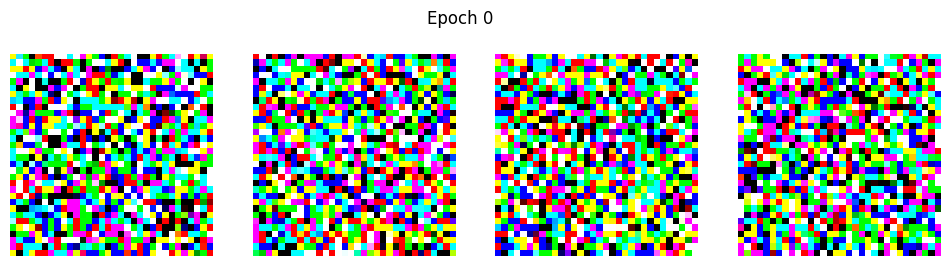

epoch 1 loss 1.0244
epoch 2 loss 0.9619
epoch 3 loss 0.9456
epoch 4 loss 0.9431
epoch 5 loss 0.8702


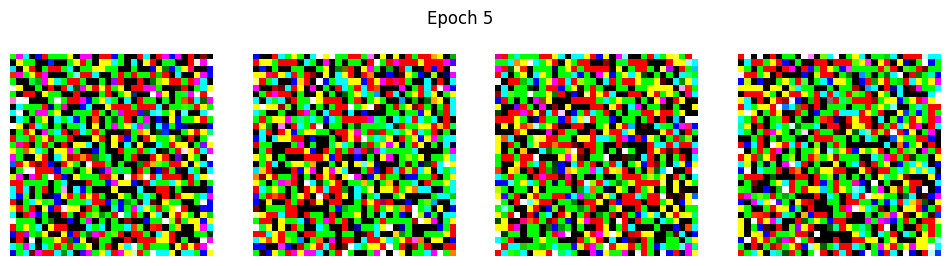

epoch 6 loss 0.8535
epoch 7 loss 0.8126
epoch 8 loss 0.6663
epoch 9 loss 0.8836
epoch 10 loss 0.7185


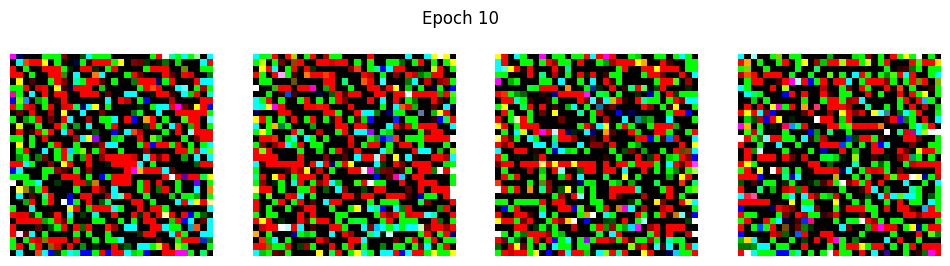

epoch 11 loss 0.7349
epoch 12 loss 0.5460
epoch 13 loss 0.3789
epoch 14 loss 0.5569
epoch 15 loss 0.3365


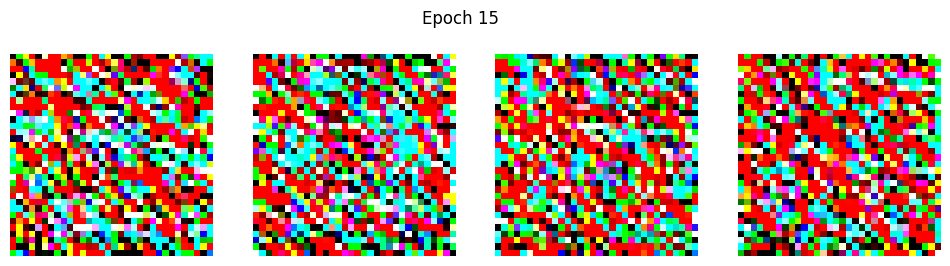

epoch 16 loss 0.3036
epoch 17 loss 0.2765
epoch 18 loss 0.8545
epoch 19 loss 0.2205
epoch 20 loss 0.4592


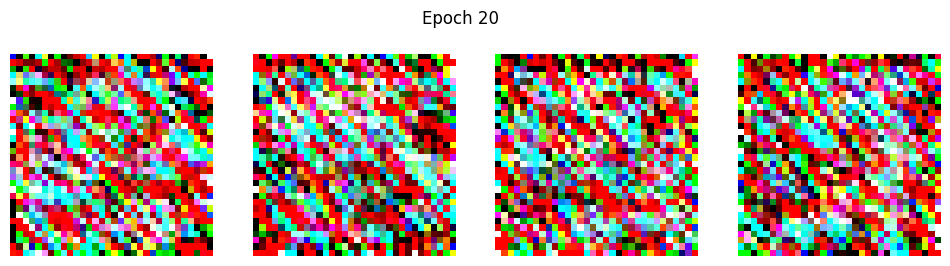

epoch 21 loss 0.1808
epoch 22 loss 0.2512
epoch 23 loss 0.1595
epoch 24 loss 0.2966
epoch 25 loss 0.1419


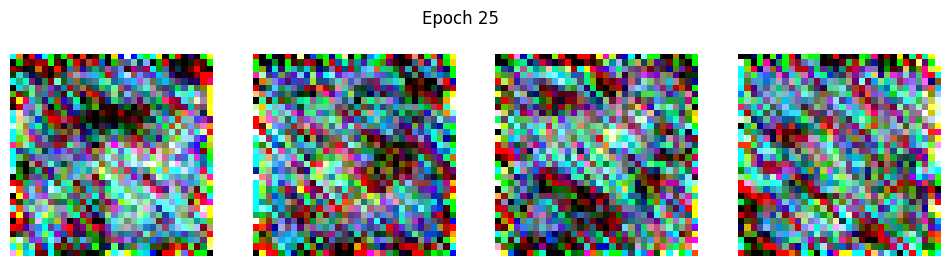

epoch 26 loss 0.1351
epoch 27 loss 0.1961
epoch 28 loss 0.1141
epoch 29 loss 0.1167
epoch 30 loss 0.1118


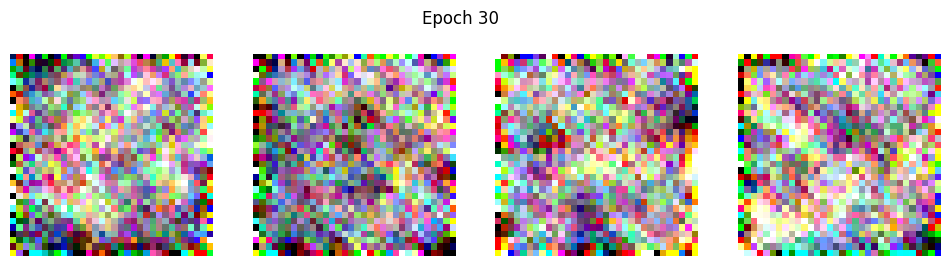

epoch 31 loss 0.1071
epoch 32 loss 0.1088
epoch 33 loss 0.0932
epoch 34 loss 0.0860
epoch 35 loss 0.0970


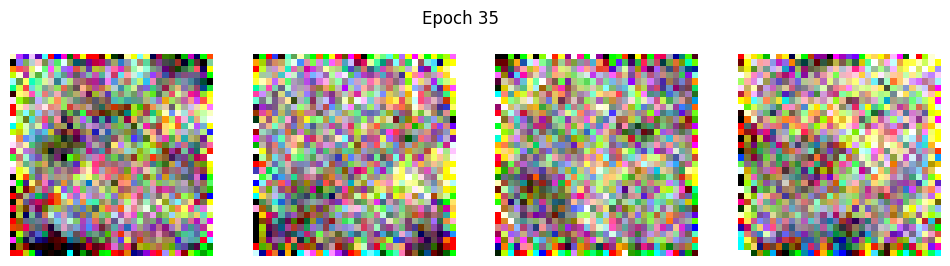

epoch 36 loss 0.0959
epoch 37 loss 0.0912
epoch 38 loss 0.1049
epoch 39 loss 0.0883
epoch 40 loss 0.0858


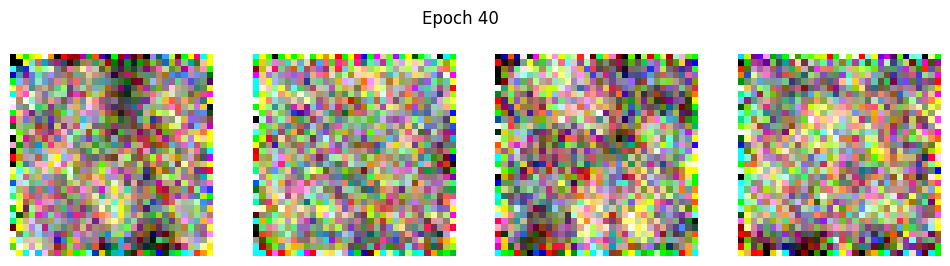

epoch 41 loss 0.0829
epoch 42 loss 0.0834
epoch 43 loss 0.0751
epoch 44 loss 0.0790
epoch 45 loss 0.1197


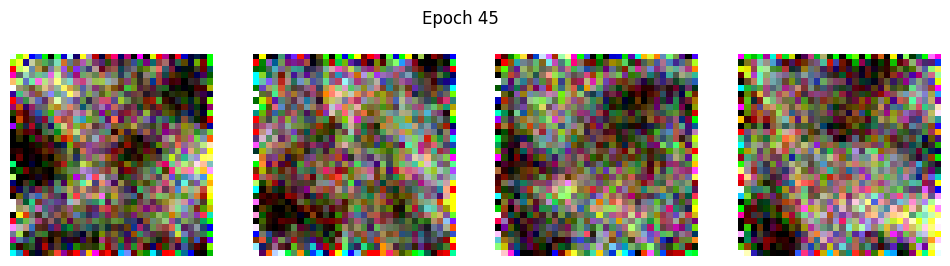

epoch 46 loss 0.2583
epoch 47 loss 0.0854
epoch 48 loss 0.3824
epoch 49 loss 0.0904
epoch 50 loss 0.0857


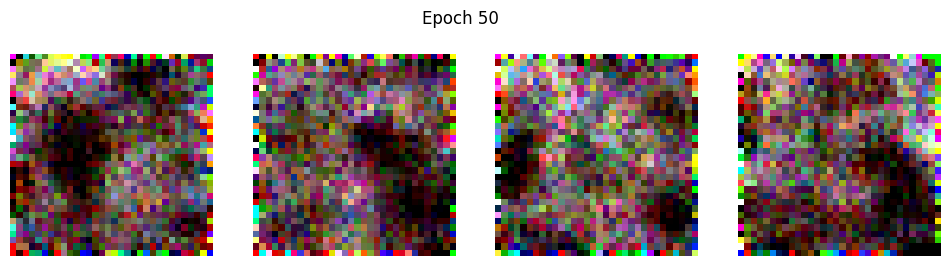

epoch 51 loss 0.0939
epoch 52 loss 0.1917
epoch 53 loss 0.0832
epoch 54 loss 0.0832
epoch 55 loss 0.2021


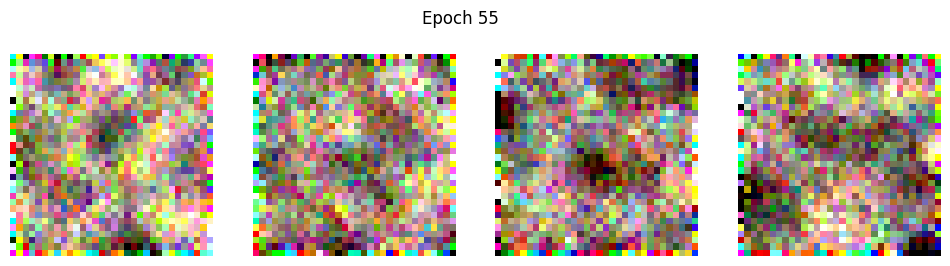

epoch 56 loss 0.3241
epoch 57 loss 0.1166
epoch 58 loss 0.0824
epoch 59 loss 0.5514
epoch 60 loss 0.0869


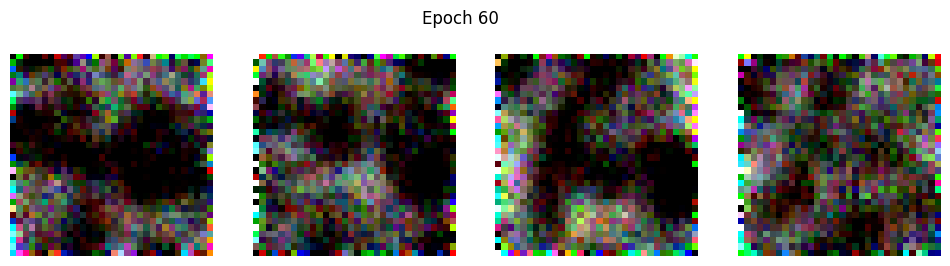

epoch 61 loss 0.0792
epoch 62 loss 0.0726
epoch 63 loss 0.0948
epoch 64 loss 0.1100
epoch 65 loss 0.0773


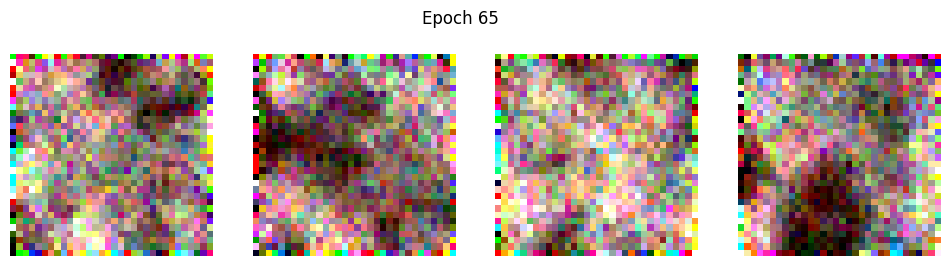

epoch 66 loss 0.2043
epoch 67 loss 0.0731
epoch 68 loss 0.4760
epoch 69 loss 0.0792
epoch 70 loss 0.0730


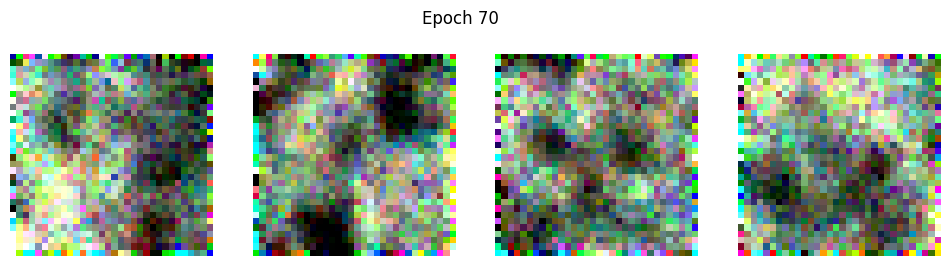

epoch 71 loss 0.0794
epoch 72 loss 0.1341
epoch 73 loss 0.1213
epoch 74 loss 0.1661
epoch 75 loss 0.0747


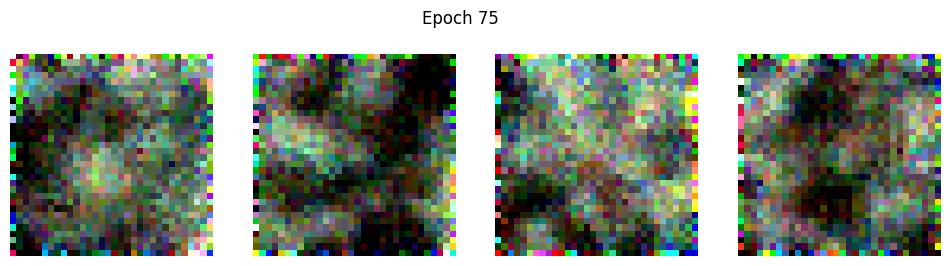

epoch 76 loss 0.0698
epoch 77 loss 0.1759
epoch 78 loss 0.0958
epoch 79 loss 0.0689
epoch 80 loss 0.0655


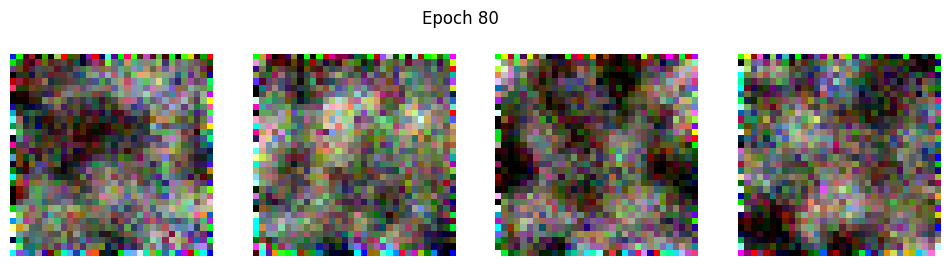

epoch 81 loss 0.4752
epoch 82 loss 0.3633
epoch 83 loss 0.0749
epoch 84 loss 0.0683
epoch 85 loss 0.0723


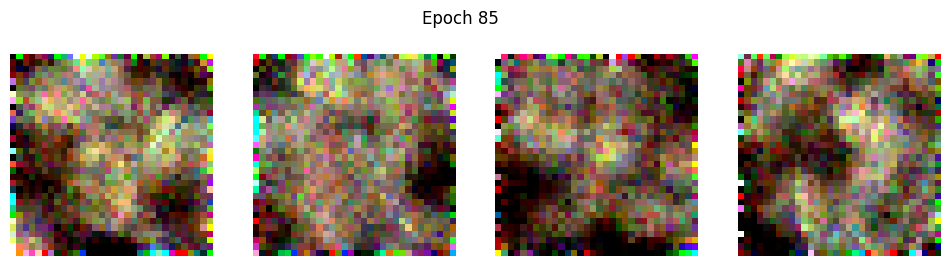

epoch 86 loss 0.0641
epoch 87 loss 0.0732
epoch 88 loss 0.0742
epoch 89 loss 0.1057
epoch 90 loss 0.0657


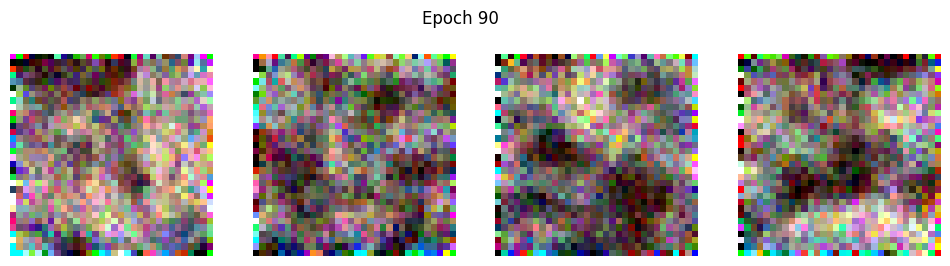

epoch 91 loss 0.0850
epoch 92 loss 0.0660
epoch 93 loss 0.0632
epoch 94 loss 0.0891
epoch 95 loss 0.0709


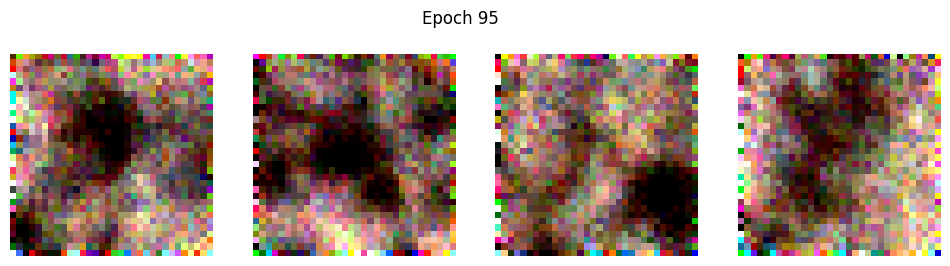

epoch 96 loss 0.3346
epoch 97 loss 0.1211
epoch 98 loss 0.0663
epoch 99 loss 0.0666


In [285]:
model = TinyUNet().to(device)
opt = torch.optim.Adam(model.parameters(), lr=3e-4)

fixed_latent = torch.randn(1, 3, 32, 32).to(device)

training_frames = []

for epoch in range(100):
    for x, _ in loader:
        x = x.to(device)

        t = torch.randint(0, T, (x.size(0),), device=device)
        noise = torch.randn_like(x)

        x_noisy = torch.stack([
            q_sample(x[i], t[i], noise[i])
            for i in range(x.size(0))
        ])

        pred_noise = model(x_noisy, t)
        loss = F.mse_loss(pred_noise, noise)

        opt.zero_grad()
        loss.backward()
        opt.step()

    print(f"epoch {epoch} loss {loss.item():.4f}")

    if epoch % 5 == 0:
        samples = sample(model, (4, 3, 32, 32))
        show_samples(samples, epoch)
        
    frame = generate_epoch_frame(model, fixed_latent)
    training_frames.append(frame)

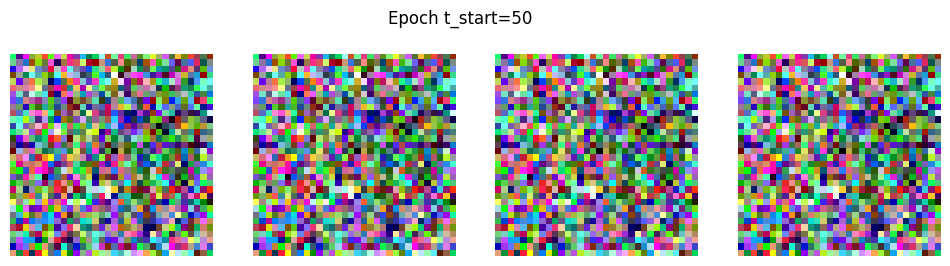

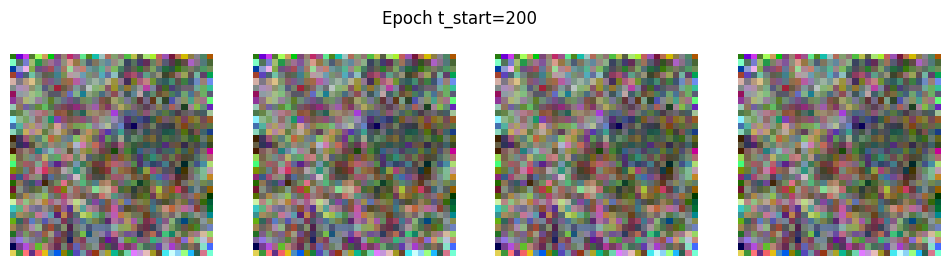

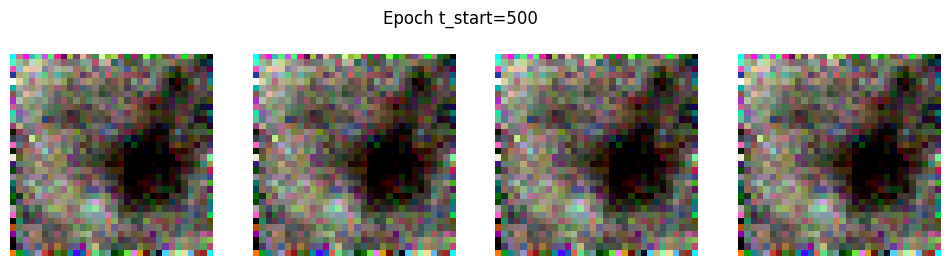

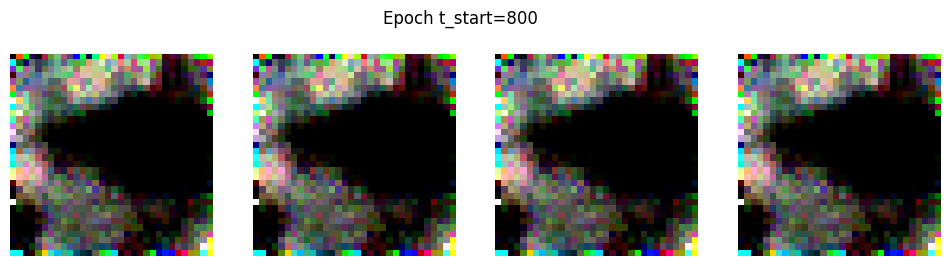

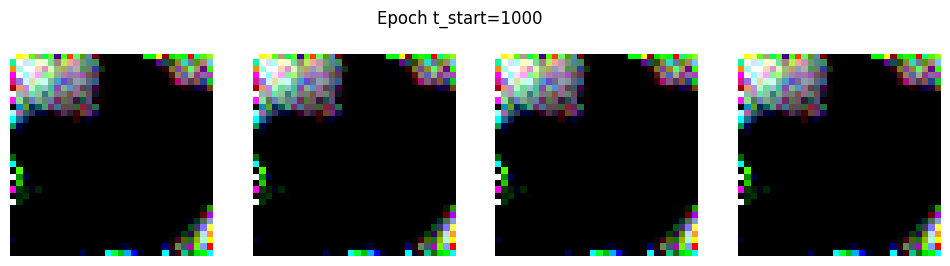

In [286]:
for t_test in [50, 200, 500, 800, 1000]:
    frame = sample(model, x_init=fixed_latent, t_time=t_test)
    show_samples(frame.repeat(4,1,1,1), f"t_start={t_test}")

In [287]:
imageio.mimsave(
    "training_progress.mp4",
    training_frames,
    fps=2
)

print("Saved training_progress.mp4")

Saved training_progress.mp4


In [288]:
samples = sample_ddim(
    model,
    x_init=fixed_latent.repeat(4,1,1,1),
    steps=30
)

In [289]:
samples = (samples + 1) / 2
samples = samples.clamp(0, 1)

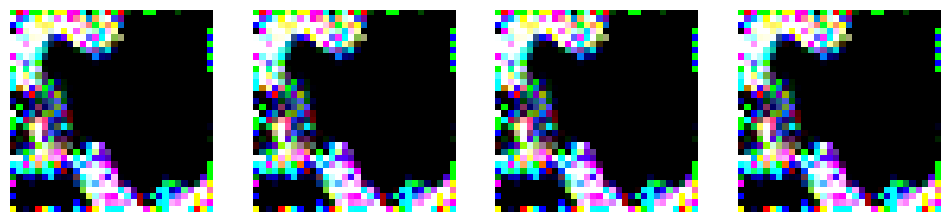

In [290]:
grid = samples.cpu().permute(0, 2, 3, 1)

fig, axs = plt.subplots(1, grid.size(0), figsize=(12, 3))
for i, ax in enumerate(axs):
    ax.imshow(grid[i])
    ax.axis("off")

plt.show()

In [291]:
from torchvision.utils import save_image

save_image(samples, "generated.png", nrow=4)